In [220]:
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn import svm

import matplotlib.pyplot as plt

from xgboost import XGBClassifier


# Necessary to get names out
SimpleImputer.get_feature_names_out = (lambda self, names=None:
                                       self.feature_names_in_)

In [148]:
def get_X_y(data):
    """"
    Returns the X and y of the data

    :returns X, y
    """
    return data.loc[:, data.columns != 'Classification'], data['Classification']



In [149]:
# Creating the pipeline
features_num = [
    "AGNfrac_af", "AGNfrac_af_16", "AGNfrac_cg_s", "AGNfrac_cg_s_16", "AGNfrac_cg_f", "AGNfrac_cg_f_16", 
    "Chi_sq_MpBp", "Chi_sq_AfCg", "Mass_conc", "SFR_conc", "Radio_excess", "Radio_excess_DJS"
]
features_cat = [
    "Spitzer_SN", "Donley", "Lacy", "Stern", "Messias", "KI", "Ch2_Ch4", 
    "Ch4_24mu", "Xray", "Opt_spec", "Extended_radio"
]
features_drop = [
    "Source_Name", "Radio_ID", "AGN_final", "IDOptical", "IDSpitzer"
]
transformer_num = make_pipeline(
    SimpleImputer(),  # there are a few missing values
    StandardScaler(),
)
transformer_cat = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown='ignore'),
)

preprocessor = make_column_transformer(
    (transformer_num, features_num),
    (transformer_cat, features_cat),
)

In [150]:
data = pd.read_csv("../Data/Cleaned/Combined_secure_class.csv")
X, y = get_X_y(data)
X = X.drop(columns=features_drop)

# Transforming y from categorical to numerical
le = preprocessing.LabelEncoder()
labels = np.unique(y)
y = le.fit_transform(y)

C:\Users\jespe\AppData\Local\Temp\ipykernel_3952\22415563.py:1: DtypeWarning: Columns (30,31) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("../Data/Cleaned/Combined_secure_class.csv")


In [151]:
# Creating training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7)

In [152]:
# Transforming the data
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

# Random Forest

In [230]:
clf = RandomForestClassifier(n_estimators=10, class_weight=None)
clf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=10)

In [232]:
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred, target_names=labels, digits=4))

                                                      precision    recall  f1-score   support

      jet-mode radio AGN/low-excitation radio galaxy     0.9621    0.9838    0.9728      3891
quasar-like radio AGN / high-excitation radio galaxy     0.8337    0.8638    0.8485       389
                                     radio-quiet AGN     0.9396    0.9323    0.9359      2052
                                 star-forming galaxy     0.9916    0.9866    0.9891     16951

                                            accuracy                         0.9793     23283
                                           macro avg     0.9318    0.9416    0.9366     23283
                                        weighted avg     0.9795    0.9793    0.9794     23283



[]

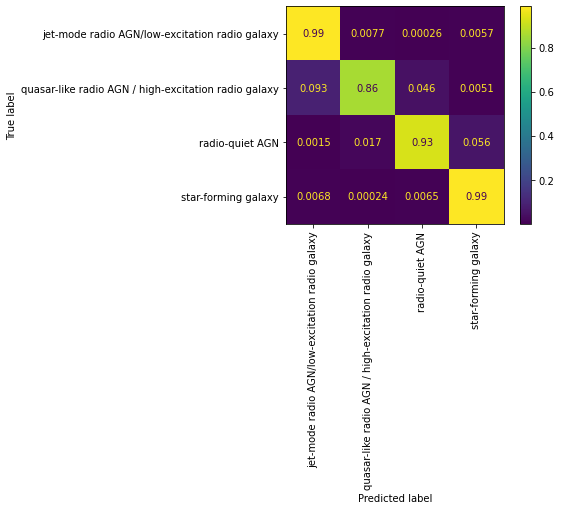

In [188]:
cm = confusion_matrix(y_test, y_pred, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()
plt.xticks(rotation = 90)
plt.plot()

In [162]:
random_forest_feature_importance = pd.DataFrame(
    np.array([preprocessor.get_feature_names_out(), clf.feature_importances_]).T,
                                               columns=['Feature', 'Importance'])

[Text(0, 0, 'pipeline-1__AGNfrac_af'),
 Text(1, 0, 'pipeline-1__AGNfrac_af_16'),
 Text(2, 0, 'pipeline-1__AGNfrac_cg_s'),
 Text(3, 0, 'pipeline-1__AGNfrac_cg_s_16'),
 Text(4, 0, 'pipeline-1__AGNfrac_cg_f'),
 Text(5, 0, 'pipeline-1__AGNfrac_cg_f_16'),
 Text(6, 0, 'pipeline-1__Chi_sq_MpBp'),
 Text(7, 0, 'pipeline-1__Chi_sq_AfCg'),
 Text(8, 0, 'pipeline-1__Mass_conc'),
 Text(9, 0, 'pipeline-1__SFR_conc'),
 Text(10, 0, 'pipeline-1__Radio_excess'),
 Text(11, 0, 'pipeline-1__Radio_excess_DJS'),
 Text(12, 0, 'pipeline-2__Spitzer_SN_0.0'),
 Text(13, 0, 'pipeline-2__Spitzer_SN_1.0'),
 Text(14, 0, 'pipeline-2__Spitzer_SN_2.0'),
 Text(15, 0, 'pipeline-2__Donley_0.0'),
 Text(16, 0, 'pipeline-2__Donley_1.0'),
 Text(17, 0, 'pipeline-2__Lacy_0.0'),
 Text(18, 0, 'pipeline-2__Lacy_1.0'),
 Text(19, 0, 'pipeline-2__Stern_0.0'),
 Text(20, 0, 'pipeline-2__Stern_1.0'),
 Text(21, 0, 'pipeline-2__Messias_0.0'),
 Text(22, 0, 'pipeline-2__Messias_1.0'),
 Text(23, 0, 'pipeline-2__KI_-99.0'),
 Text(24, 0, 'pipeli

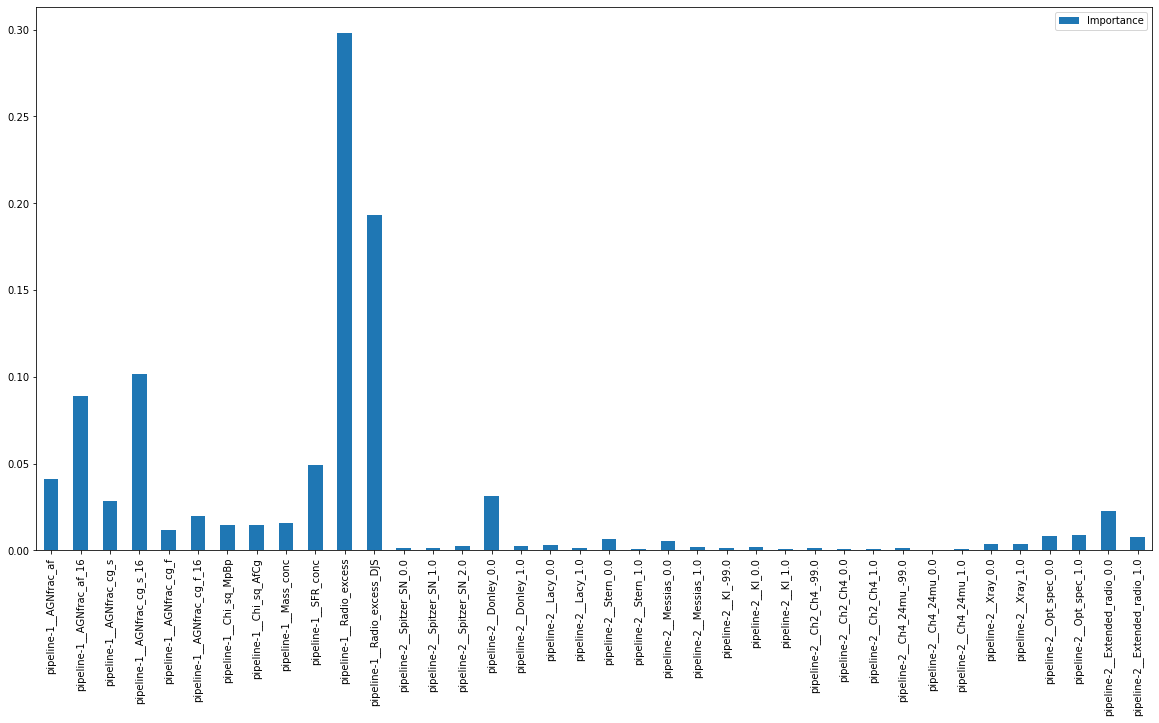

In [169]:
ax = random_forest_feature_importance.plot(kind='bar', figsize=(20,10))
ax.set_xticklabels(random_forest_feature_importance.Feature)

# XGBoost

In [234]:
model = XGBClassifier(use_label_encoder=False, max_depth=7)
model.fit(X_train, y_train, early_stopping_rounds=10, eval_set=[(X_test, y_test)], verbose=True)

[22:53:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:0.87671
[1]	validation_0-mlogloss:0.61388
[2]	validation_0-mlogloss:0.44791
[3]	validation_0-mlogloss:0.33524
[4]	validation_0-mlogloss:0.25631
[5]	validation_0-mlogloss:0.19990
[6]	validation_0-mlogloss:0.15927
[7]	validation_0-mlogloss:0.12957
[8]	validation_0-mlogloss:0.10769
[9]	validation_0-mlogloss:0.09131
[10]	validation_0-mlogloss:0.07923
[11]	validation_0-mlogloss:0.07029
[12]	validation_0-mlogloss:0.06361
[13]	validation_0-mlogloss:0.05845
[14]	validation_0-mlogloss:0.05470
[15]	validation_0-mlogloss:0.05172
[16]	validation_0-mlogloss:0.04951
[17]	validation_0-mlogloss:0.04771
[18]	validation_0-mlogloss:0.04631
[19]	validation_0-mlogloss:0.04518

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=7, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=1, tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [235]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=labels, digits=4))

                                                      precision    recall  f1-score   support

      jet-mode radio AGN/low-excitation radio galaxy     0.9744    0.9874    0.9809      3891
quasar-like radio AGN / high-excitation radio galaxy     0.8640    0.8817    0.8728       389
                                     radio-quiet AGN     0.9527    0.9527    0.9527      2052
                                 star-forming galaxy     0.9944    0.9909    0.9927     16951

                                            accuracy                         0.9851     23283
                                           macro avg     0.9464    0.9532    0.9498     23283
                                        weighted avg     0.9852    0.9851    0.9852     23283



In [217]:
xgboost_feature_importance = pd.DataFrame(
    np.array([preprocessor.get_feature_names_out(), model.feature_importances_]).T,
                                               columns=['Feature', 'Importance'])

[Text(0, 0, 'pipeline-1__AGNfrac_af'),
 Text(1, 0, 'pipeline-1__AGNfrac_af_16'),
 Text(2, 0, 'pipeline-1__AGNfrac_cg_s'),
 Text(3, 0, 'pipeline-1__AGNfrac_cg_s_16'),
 Text(4, 0, 'pipeline-1__AGNfrac_cg_f'),
 Text(5, 0, 'pipeline-1__AGNfrac_cg_f_16'),
 Text(6, 0, 'pipeline-1__Chi_sq_MpBp'),
 Text(7, 0, 'pipeline-1__Chi_sq_AfCg'),
 Text(8, 0, 'pipeline-1__Mass_conc'),
 Text(9, 0, 'pipeline-1__SFR_conc'),
 Text(10, 0, 'pipeline-1__Radio_excess'),
 Text(11, 0, 'pipeline-1__Radio_excess_DJS'),
 Text(12, 0, 'pipeline-2__Spitzer_SN_0.0'),
 Text(13, 0, 'pipeline-2__Spitzer_SN_1.0'),
 Text(14, 0, 'pipeline-2__Spitzer_SN_2.0'),
 Text(15, 0, 'pipeline-2__Donley_0.0'),
 Text(16, 0, 'pipeline-2__Donley_1.0'),
 Text(17, 0, 'pipeline-2__Lacy_0.0'),
 Text(18, 0, 'pipeline-2__Lacy_1.0'),
 Text(19, 0, 'pipeline-2__Stern_0.0'),
 Text(20, 0, 'pipeline-2__Stern_1.0'),
 Text(21, 0, 'pipeline-2__Messias_0.0'),
 Text(22, 0, 'pipeline-2__Messias_1.0'),
 Text(23, 0, 'pipeline-2__KI_-99.0'),
 Text(24, 0, 'pipeli

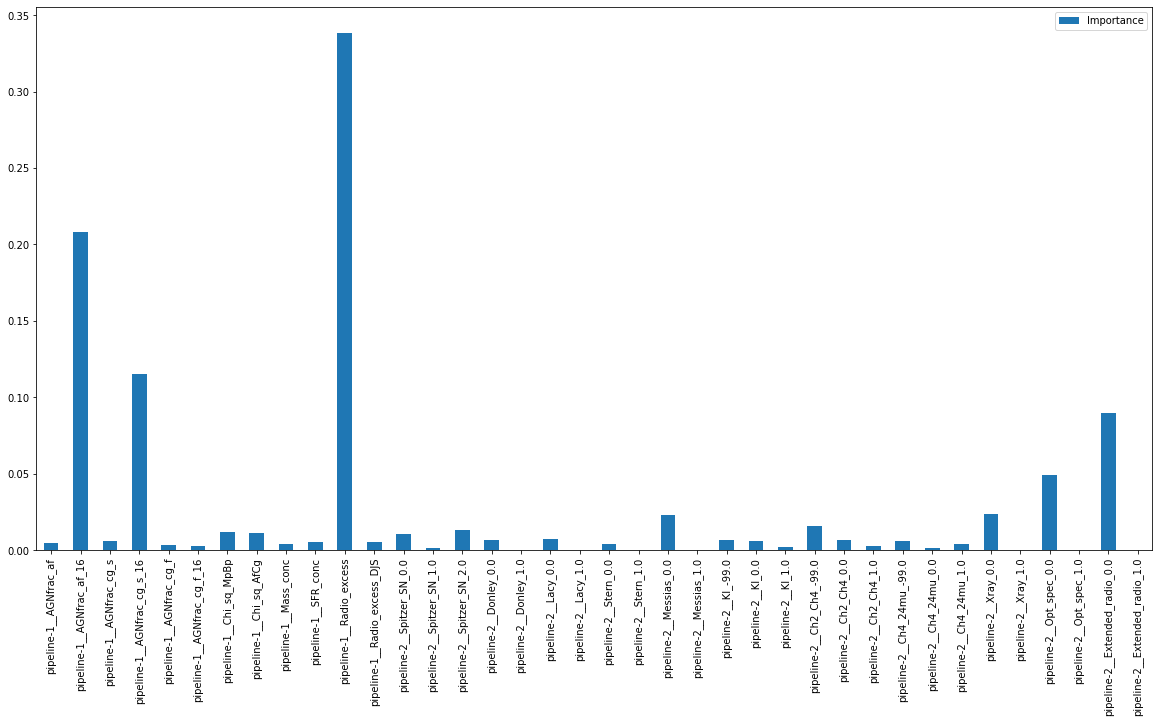

In [218]:
ax = xgboost_feature_importance.plot(kind='bar', figsize=(20,10))
ax.set_xticklabels(xgboost_feature_importance.Feature)

# SVM

In [221]:
clf = svm.SVC()
clf.fit(X_train, y_train)

SVC()

In [236]:
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred, target_names=labels, digits=4))

                                                      precision    recall  f1-score   support

      jet-mode radio AGN/low-excitation radio galaxy     0.9621    0.9838    0.9728      3891
quasar-like radio AGN / high-excitation radio galaxy     0.8337    0.8638    0.8485       389
                                     radio-quiet AGN     0.9396    0.9323    0.9359      2052
                                 star-forming galaxy     0.9916    0.9866    0.9891     16951

                                            accuracy                         0.9793     23283
                                           macro avg     0.9318    0.9416    0.9366     23283
                                        weighted avg     0.9795    0.9793    0.9794     23283

